# Predicting yeilds.

There are 10^10 stars in the LMC and 5x10^9 stars in the SMC. The DEC detector has 62 chips, 4k x 4k. 16Mpixels. 10^5 stars per chip.

In [1]:
Nstars = 10**5 * 62
Nstars

6200000

Around 0.2% of stars have hot Jupiters.

In [2]:
NhotJs = .002 * Nstars
NhotJs

12400.0

But not all of these will transit.

In [159]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import batman
from tqdm import tqdm
from tqdm import trange

plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'legend.fontsize': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [4]:
df = pd.read_csv("KOIs.csv", skiprows=53)
for i in df.keys():
    print(i)

loc_rowid
kepid
kepoi_name
kepler_name
koi_disposition
koi_pdisposition
koi_score
koi_fpflag_nt
koi_fpflag_ss
koi_fpflag_co
koi_fpflag_ec
koi_period
koi_period_err1
koi_period_err2
koi_time0bk
koi_time0bk_err1
koi_time0bk_err2
koi_impact
koi_impact_err1
koi_impact_err2
koi_duration
koi_duration_err1
koi_duration_err2
koi_depth
koi_depth_err1
koi_depth_err2
koi_prad
koi_prad_err1
koi_prad_err2
koi_teq
koi_teq_err1
koi_teq_err2
koi_insol
koi_insol_err1
koi_insol_err2
koi_model_snr
koi_tce_plnt_num
koi_tce_delivname
koi_steff
koi_steff_err1
koi_steff_err2
koi_slogg
koi_slogg_err1
koi_slogg_err2
koi_srad
koi_srad_err1
koi_srad_err2
ra
dec
koi_kepmag


Select G stars and remove false positives.

In [5]:
m = df.koi_steff.values < 6000
m &= 5200 < df.koi_steff.values
m &= df.koi_pdisposition.values == "CANDIDATE"
m &= df.koi_disposition.values == "CONFIRMED"

m2 = df.koi_pdisposition.values == "CANDIDATE"
m2 &= df.koi_disposition.values == "CONFIRMED"

df_G = df.iloc[m]

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


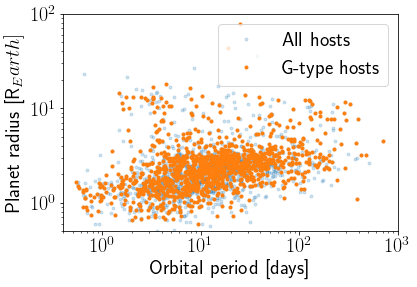

In [6]:
plt.loglog(df.koi_period.values[m2], df.koi_prad.values[m2], ".", alpha=.2, label="All hosts")
plt.loglog(df_G.koi_period, df_G.koi_prad, ".", label="G-type hosts")
plt.xlabel("Orbital period [days]")
plt.ylabel("Planet radius [R_Earth]")
plt.ylim(.5, 100)
plt.xlim(.4, 1000)
plt.legend()

Text(0,0.5,'Depth')

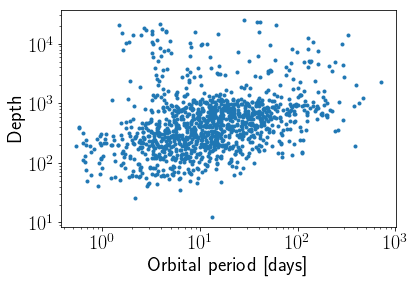

In [7]:
plt.loglog(df_G.koi_period, df_G.koi_depth, ".")
plt.xlabel("Orbital period [days]")
plt.ylabel("Depth")

114
9564


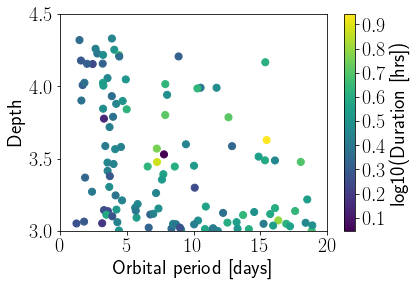

In [8]:
m = df_G.koi_period.values < 20
m &= np.log10(df_G.koi_depth) < 4.5
m &= 3 < np.log10(df_G.koi_depth)
plt.scatter(df_G.koi_period.values[m], np.log10(df_G.koi_depth.values[m]), 
            c=np.log10(df_G.koi_duration.values[m]), s=50)
plt.xlabel("Orbital period [days]")
plt.ylabel("Depth")
plt.ylim(3, 4.5)
plt.xlim(0, 20)
plt.colorbar(label="log10(Duration [hrs])")
print(sum(m))
print(len(df))

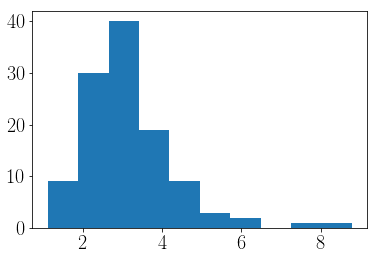

In [9]:
plt.hist(df_G.koi_duration.values[m]);

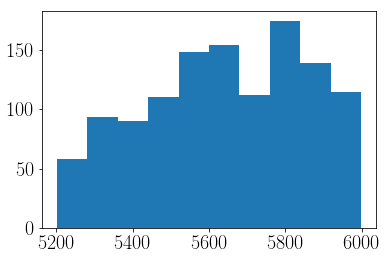

In [10]:
plt.hist(df_G.koi_steff);

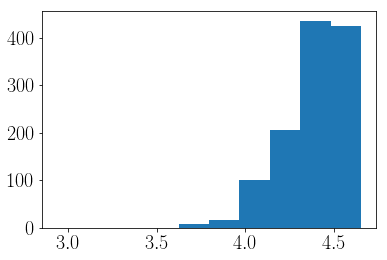

In [11]:
plt.hist(df_G.koi_slogg);

In [12]:
print(len(df.iloc[df.koi_disposition.values=="CONFIRMED"]))

2297


Cadence is around 5 minutes, 23.5 magnitude, S/N = 10. Minimum number of nights needed to observe 1/2 of these.
4 nights in a row is the minimum requirement - but to find subgiants longer baselines are needed. 5% precision.

look at distribution of orbital periods of CVs. Durations are 5 - 10%. 

Simulate a light curve.

In [13]:
import astropy.constants as co
import astropy.units as u

In [14]:
period_days = 1.  # period in days
cadence_minutes = 5  # cadence in minutes
radius = 2 * co.R_jup/co.R_sun  # 1 Jupiter radius in stellar radii
precision = 5  # percent

In [15]:
def make_light_curve(period_days, cadence_minutes, radius, precision, baseline=20):
    period_s = period_days * 24 * 3600
    period_s = period_s*u.s
    G = 6.67e-11
    M = 2e30
    a = (period_s**2*co.G*co.M_sun/(4*np.pi**2))**(1./3)/co.R_sun

    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = period_days # period_days                   #orbital period
    params.rp = radius                       #planet radius (in units of stellar radii)
    params.a = a # (period_s**2*G*M/(4*np.pi**2))/6.955e8  #semi-major axis (in units of stellar radii)
    params.inc = 90.                      #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "nonlinear"        #limb darkening model
    params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients

    cadence = cadence_minutes/(24*60)  # 30 minute cadence in days
    t = np.arange(0, baseline, cadence)  #times at which to calculate light curve [days]
    m = batman.TransitModel(params, t)    #initializes model

    flux = m.light_curve(params)          #calculates light curve

    f = flux + np.random.randn(len(t))*precision*1e-2
    
    return t, f

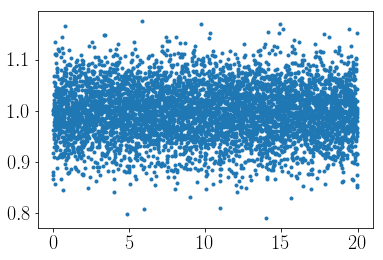

In [16]:
t, f = make_light_curve(period_days, cadence_minutes, radius, precision)
plt.plot(t, f, ".")

In [17]:
from astropy.stats import BoxLeastSquares

model = BoxLeastSquares(t, f, dy=precision*1e-2)
periodogram = model.autopower(0.2)

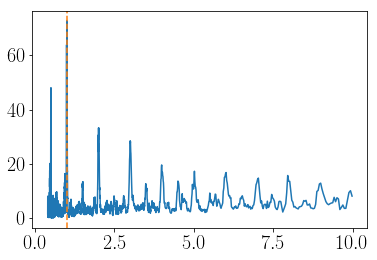

In [18]:
plt.plot(periodogram.period, periodogram.power)
plt.axvline(period_days, color="tab:orange", ls="--")

In [19]:
print(periodogram.period[periodogram.power == max(periodogram.power)][0])

1.0005212405485844


Now try a range of radii and orbital periods.

In [342]:
Ntrials = 24
Norbs = 10
Nrads = 8
porbs = 10**(np.linspace(.01, np.log10(20), Norbs))
radii = np.linspace(.5, 2, Nrads)*co.R_jup/co.R_sun
recovered, true_p = [np.zeros((Norbs, Nrads, Ntrials)) for i in range(2)]

print("porbs = ", porbs)
print("radii = ", radii)

for k in tqdm(range(Ntrials)):
    for i in range(Norbs):
        for j in range(Nrads):
            t, f = make_light_curve(porbs[i], cadence_minutes, radii[j], precision)
            model = BoxLeastSquares(t, f, dy=precision*1e-2)
            periodogram = model.autopower(0.2)
            recovered[i, j, k] = periodogram.period[periodogram.power == max(periodogram.power)][0]
            true_p[i, j, k] = porbs[i]
            
            # Make plots
            plt.plot(periodogram.period, periodogram.power)
            plt.axvline(porbs[i], color="tab:orange", ls="--")
            plt.savefig("plots/{0}{1}{2}".format(i, j, k))
            plt.close()
            plt.plot(t, f, ".")
            plt.savefig("plots/{0}{1}{2}_lc".format(i, j, k))
            plt.close()

  0%|          | 0/16 [00:00<?, ?it/s]

porbs =  [ 1.02329299  1.56470639  2.39257584  3.65846218  5.59411546  8.55390224
 13.07968061 20.        ]
radii =  [0.05138134 0.08221015 0.11303895 0.14386776 0.17469656 0.20552537]


100%|██████████| 16/16 [07:56<00:00, 29.42s/it]


Were the recovered periods within 10% of the injected ones?

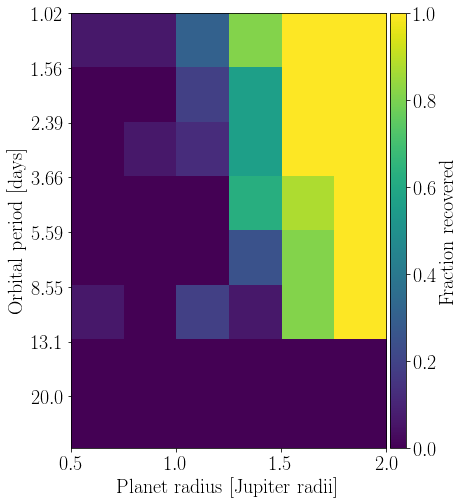

In [343]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

success = true_p/abs(true_p - recovered)
success_hist = np.zeros((Norbs, Nrads))

for i in range(Norbs):
    for j in range(Nrads):
        success = abs(true_p[i, j, :] - recovered[i, j, :])/true_p[i, j, :]
        s = success <= .1
        success_hist[i, j] = float(sum(s))/Ntrials
        
rjup = co.R_jup/co.R_sun

fig, ax = plt.subplots(figsize=(Nrads*1, Norbs*1))
img = ax.imshow(success_hist, extent=[radii[0]/rjup, radii[-1]/rjup, porbs[1], porbs[0]], aspect="auto")
tlabels = []
tmarks = np.linspace(porbs[0], 1.5, Norbs)
for p in porbs:
    tlabels.append("${0:.3}$".format(p))
ax.set_yticks(tmarks)
ax.set_yticklabels(tlabels)
plt.xlabel("$\mathrm{Planet~radius~[Jupiter~radii]}$")
plt.ylabel("$\mathrm{Orbital~period~[days]}$")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(img, ax=ax, cax=cax, label="$\mathrm{Fraction~recovered}$")
plt.subplots_adjust
plt.savefig("completeness.pdf")

# Now with a more realistic observing strategy (6 hours per night).

In [20]:
def make_light_curve_nights(period_days, cadence_minutes, radius, precision, baseline=20):
    period_s = period_days * 24 * 3600
    period_s = period_s*u.s
    G = 6.67e-11
    M = 2e30
    a = (period_s**2*co.G*co.M_sun/(4*np.pi**2))**(1./3)/co.R_sun

    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = period_days # period_days                   #orbital period
    params.rp = radius                       #planet radius (in units of stellar radii)
    params.a = a # (period_s**2*G*M/(4*np.pi**2))/6.955e8  #semi-major axis (in units of stellar radii)
    params.inc = 90.                      #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "nonlinear"        #limb darkening model
    params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients

    cadence = cadence_minutes/(24*60)  # 30 minute cadence in days
    t = np.arange(0, baseline, cadence)  #times at which to calculate light curve [days]
    
    times = []
    for i in range(baseline):
        n = 24*i < t*24
        n &= t*24 < 24*i + 6
        times += list(t[n])
    t = np.array(times)
    
    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params)          #calculates light curve
    f = flux + np.random.randn(len(t))*precision*1e-2
    return t, f

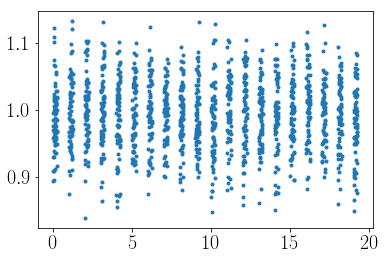

In [21]:
period_days = 1.  # period in days
cadence_minutes = 5  # cadence in minutes
radius = 2 * co.R_jup/co.R_sun  # 2 Jupiter radii in stellar radii
precision = 5  # percent

t, f = make_light_curve_nights(period_days, cadence_minutes, radius, precision)
plt.plot(t, f, ".")

In [166]:
Ntrials = 1
Norbs = 4
Nrads = 3
porbs = 10**(np.linspace(-1, np.log10(20), Norbs))
radii = np.linspace(.5, 2, Nrads)*co.R_jup/co.R_sun
recovered, true_p = [np.zeros((Norbs, Nrads, Ntrials)) for i in range(2)]

def run_bls(Ntrials, porbs, radii):
    Norbs, Nrads = len(porbs), len(radii)
    for k in range(Ntrials):
        for i in range(Norbs):
            for j in range(Nrads):
                t, f = make_light_curve_nights(porbs[i], cadence_minutes, radii[j], precision)
                model = BoxLeastSquares(t, f, dy=precision*1e-2)
                periodogram = model.autopower(0.2)
                recovered[i, j, k] = periodogram.period[periodogram.power == max(periodogram.power)][0]
                true_p[i, j, k] = porbs[i]
            
                # Make plots
                plt.plot(periodogram.period, periodogram.power)
                plt.axvline(porbs[i], color="tab:orange", ls="--")
                plt.savefig("plots/{0}{1}{2}".format(i, j, k))
                plt.close()
                plt.plot(t, f, ".")
                plt.savefig("plots/{0}{1}{2}_lc".format(i, j, k))
                plt.close()
    return recovered, true_p

In [167]:
recovered, true_p = run_bls(Ntrials, porbs, radii)

100%|██████████| 1/1 [00:05<00:00,  5.10s/it]


In [54]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_plot(true_p, recovered, porbs, radii, Ntrials):
    Norbs, Nrads = len(porbs), len(radii)
    
    success = true_p/abs(true_p - recovered)
    success_hist = np.zeros((Norbs, Nrads))

    for i in range(Norbs):
        for j in range(Nrads):
            success = abs(true_p[i, j, :] - recovered[i, j, :])/true_p[i, j, :]
            s = success <= .1
            success_hist[i, j] = float(sum(s))/Ntrials
        
    rjup = co.R_jup/co.R_sun

    fig, ax = plt.subplots(figsize=(Nrads*1, Norbs*1))
    img = ax.imshow(success_hist, extent=[radii[0]/rjup, radii[-1]/rjup, porbs[1], porbs[0]], aspect="auto")
    tlabels = []
    tmarks = np.linspace(porbs[0], 1.5, Norbs)
    tmarks = porbs/10.
    for p in porbs:
        tlabels.append("${0:.3}$".format(p))
    ax.set_yticks(tmarks)
    ax.set_yticklabels(tlabels)
    plt.xlabel("$\mathrm{Planet~radius~[Jupiter~radii]}$")
    plt.ylabel("$\mathrm{Orbital~period~[days]}$")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(img, ax=ax, cax=cax, label="$\mathrm{Fraction~recovered}$")
    plt.savefig("completeness_nights2.pdf")

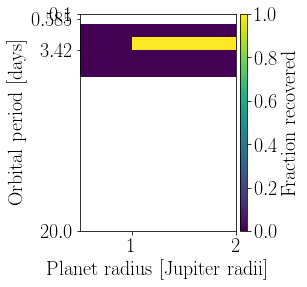

In [55]:
make_plot(true_p, recovered, porbs, radii, Ntrials)

In [189]:
rjup = co.R_jup/co.R_sun

Norbs = 10
Nrads = 12
porbs = 10**(np.random.uniform(-1, np.log10(20), Norbs))
# radii = np.random.uniform(.5, 2, Nrads)*rjup
radii = np.random.uniform(100, 1000, Nrads)*rjup
recovered, true_p, true_r = [np.zeros((Norbs, Nrads)) for i in range(3)]

def run_bls(porbs, radii):
    Norbs, Nrads = len(porbs), len(radii)
    for i in range(Norbs):
        print(i, "of", Norbs)
        for j in trange(Nrads):
            t, f = make_light_curve_nights(porbs[i], cadence_minutes, radii[j], precision)
            model = BoxLeastSquares(t, f, dy=precision*1e-2)
            periodogram = model.autopower(0.2)
            recovered[i, j] = periodogram.period[periodogram.power == max(periodogram.power)][0]
            true_p[i, j] = porbs[i]
#             true_r[i, j] = radii[i]
    return recovered, true_p#, true_r

In [190]:
recovered, true_p = run_bls(porbs, radii)

  0%|          | 0/12 [00:00<?, ?it/s]

0 of 10


  0%|          | 0/12 [00:00<?, ?it/s]

1 of 10


  0%|          | 0/12 [00:00<?, ?it/s]

2 of 10


  0%|          | 0/12 [00:00<?, ?it/s]

3 of 10


  0%|          | 0/12 [00:00<?, ?it/s]

4 of 10


  0%|          | 0/12 [00:00<?, ?it/s]

5 of 10


  0%|          | 0/12 [00:00<?, ?it/s]

6 of 10


  0%|          | 0/12 [00:00<?, ?it/s]

7 of 10


  0%|          | 0/12 [00:00<?, ?it/s]

8 of 10


  0%|          | 0/12 [00:00<?, ?it/s]

9 of 10


100%|██████████| 12/12 [00:10<00:00,  1.09it/s]


In [207]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_plot(true_p, true_r, recovered, porbs, radii):
    Norbs, Nrads = len(porbs), len(radii)
    
    #  rows = periods, columns = radii
    success = abs(true_p - recovered)/true_p
    success_m = success < .5
        
    recovered_p, recovered_r = [], []
    for row, _ in enumerate(success_m[:, 0]):
        recovered_p.append(true_p[row, :][success_m[row, :]])
        recovered_r.append(radii[success_m[row, :]]/rjup)
        
    recovered_p = np.array([i for j in recovered_p for i in j])
    recovered_r = np.array([i for j in recovered_r for i in j])

    print(recovered_p, np.shape(recovered_p))
#     print(recovered_r, np.shape(recovered_r))
    
    plt.plot(recovered_p, recovered_r, ".")
    print(porbs)
    for i in porbs:
        plt.axvline(i)
#     plt.plot(porbs, radii, ".")
    hist = plt.hist2d(recovered_p, recovered_r, bins=3)
#     print(hist)
    plt.xlabel("$\mathrm{Orbital~Period~[days]}$")
    plt.ylabel("$\mathrm{Planet~Radius~[R_J]}$")
    plt.colorbar()

#     plt.savefig("test.pdf")

[0.44753587 0.44753587 0.44753587 0.44753587 0.44753587 0.44753587
 0.44753587 0.44753587 0.44753587 0.44753587 0.44753587 0.44753587] (12,)
[ 3.36329666 10.23371868  0.44753587  0.36793242  1.34351011  7.9872399
  0.39709277  0.22186771  1.25365324  9.43055345]


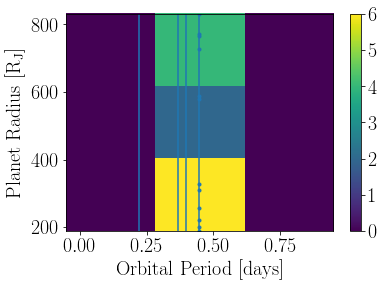

In [208]:
make_plot(true_p, true_r, recovered, porbs, radii)